In [2]:
import os
import pandas as pd

BYU_root = r"G:\.shortcut-targets-by-id\1k1B8zPb3T8H7y6x0irFZnzzmfQPHMRPx\Illimited Lab Projects\Research Projects\Spiders\BYU-UW\Tensile Testing"
UW_root = os.path.join(BYU_root, "UW")
file_name = "spec0_03062025.txt"
file_path_UW = os.path.join(UW_root, file_name)

with open(file_path_UW, 'r') as f:
    lines = f.readlines()

# Extract test segment info
segment_start = next(i for i, line in enumerate(lines) if line.startswith("TESTS SEGMENTS:")) + 1
table_start = next(i for i, line in enumerate(lines) if line.startswith("Time (s)"))

segment_lines = lines[segment_start:table_start]
test_segments = [line.strip() for line in segment_lines if line.strip()]

# Extract table header and data
header = lines[table_start].strip().split('\t')
data_lines = lines[table_start+1:]

# Convert table to DataFrame
from io import StringIO
data_str = ''.join(data_lines)
df_UW = pd.read_csv(StringIO(data_str), sep='\t', names=header)

# Example usage:
print("Test segments:")
for s in test_segments:
    print(s)

print("\nData head:")
print(df_UW.head())


Test segments:
0/Enc. 10.0E+0 sec hold; 20.0E+0 samp/s, trigger every 0 samp; 100 Hz filter
1/Enc. 68.0E-3 m,  100.0E-6 m/s ramp; 20.0E+0 samp/s, trigger every 0 samp; 100 Hz filter, Ratio=0.000, primary only
2/Enc. 30.0E+0 sec hold; 20.0E+0 samp/s, trigger every 0 samp; 100 Hz filter
3/Enc. -68.0E-3 m,  100.0E-6 m/s ramp; 20.0E+0 samp/s, trigger every 0 samp; 100 Hz filter, Ratio=0.000, primary only

Data head:
   Time (s)  Primary Encoder Displacement (m)  \
0      0.00                      3.331900e-07   
1      0.05                     -2.854317e-07   
2      0.10                      3.406405e-07   
3      0.15                     -2.600998e-07   
4      0.20                      2.613664e-07   

   Secondary Encoder Displacement (m)  Strain Gauge Load Cell (N)  \
0                        1.937151e-09                    2.985444   
1                        7.301569e-09                    1.600320   
2                        1.117587e-09                    2.259341   
3            

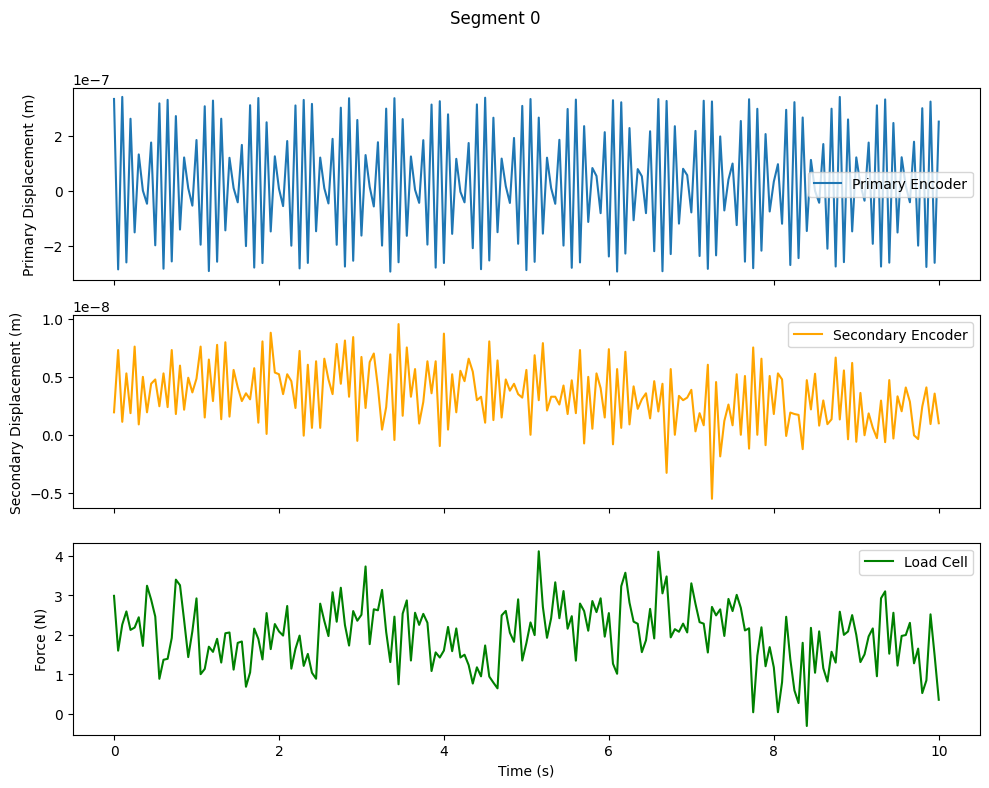

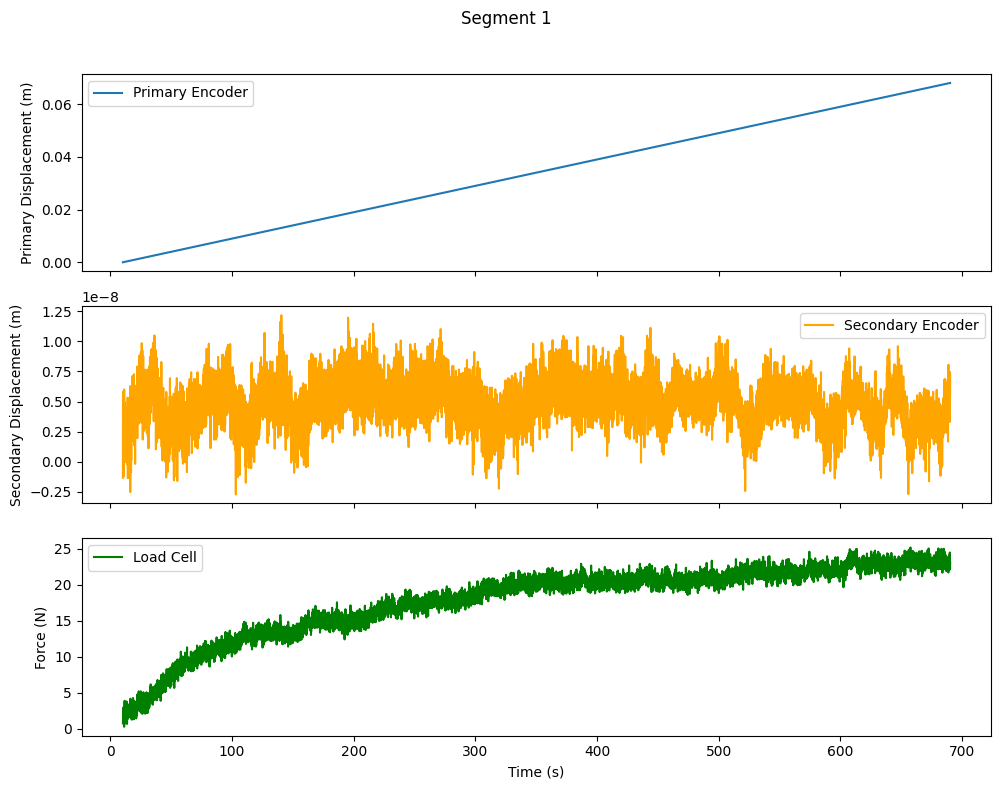

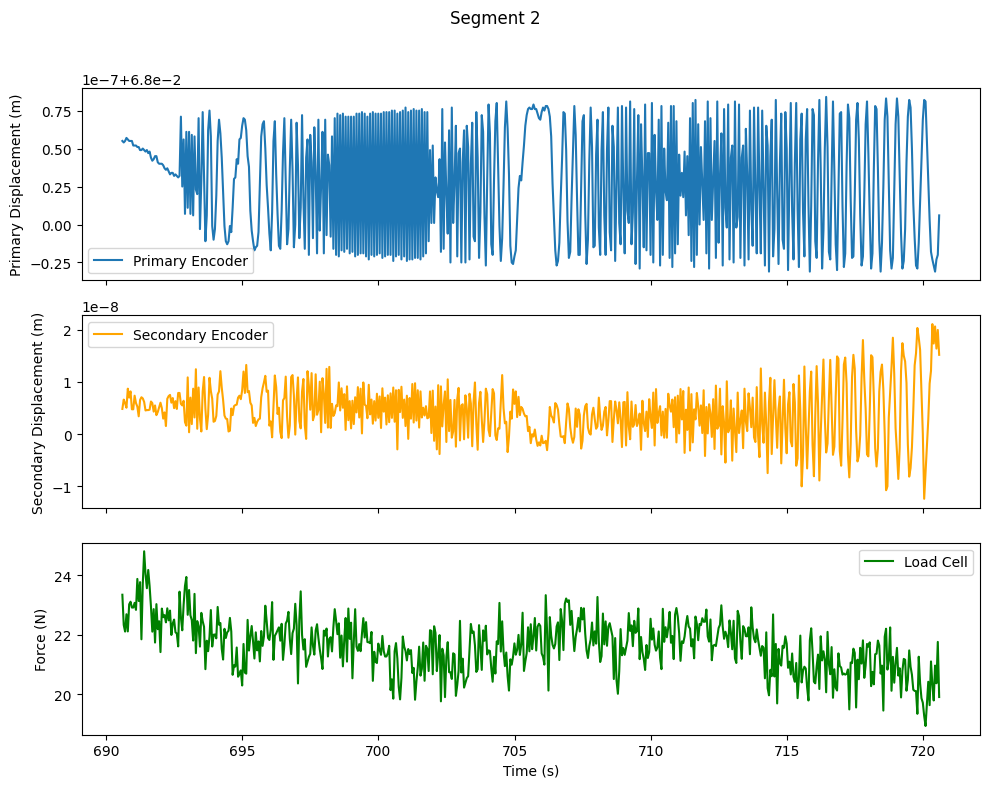

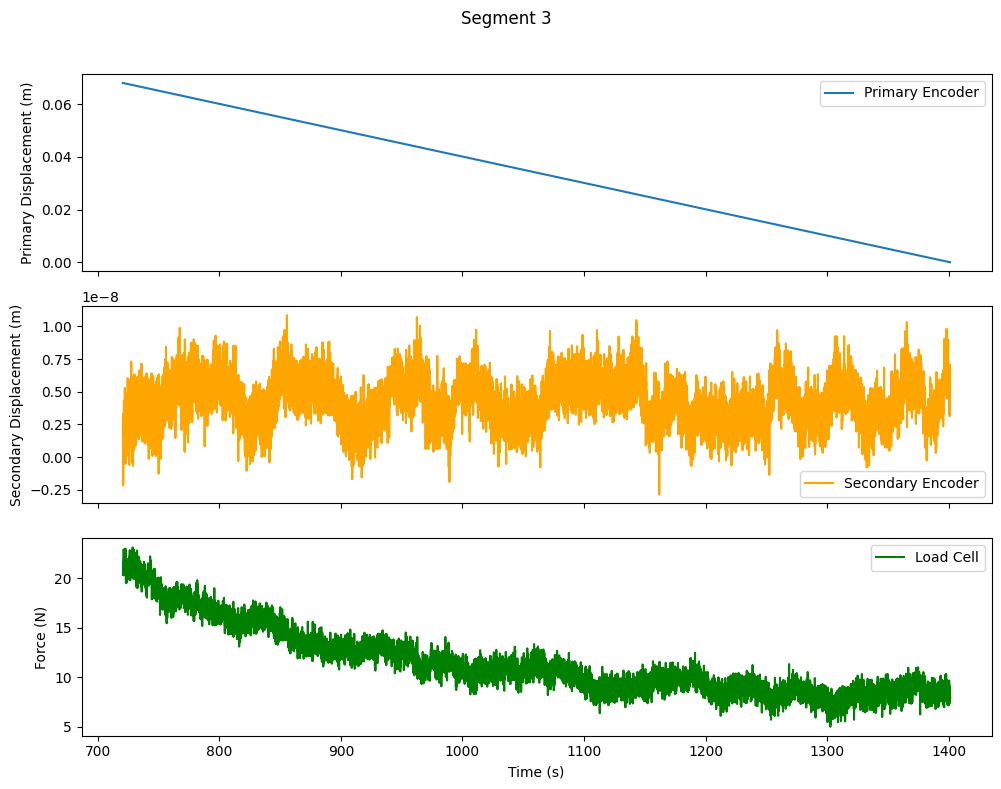

In [3]:
import matplotlib.pyplot as plt

# Ensure correct data types
df_UW["Segment No."] = df_UW["Segment No."].astype(int)

# Get the unique segment numbers
segments = df_UW["Segment No."].unique()

# Plot for each segment
for seg in segments:
    seg_df = df_UW[df_UW["Segment No."] == seg]

    fig, ax = plt.subplots(3, 1, figsize=(10, 8), sharex=True)
    fig.suptitle(f"Segment {seg}")

    ax[0].plot(seg_df["Time (s)"], seg_df["Primary Encoder Displacement (m)"], label="Primary Encoder")
    ax[0].set_ylabel("Primary Displacement (m)")
    ax[0].legend()

    ax[1].plot(seg_df["Time (s)"], seg_df["Secondary Encoder Displacement (m)"], label="Secondary Encoder", color='orange')
    ax[1].set_ylabel("Secondary Displacement (m)")
    ax[1].legend()

    ax[2].plot(seg_df["Time (s)"], seg_df["Strain Gauge Load Cell (N)"], label="Load Cell", color='green')
    ax[2].set_ylabel("Force (N)")
    ax[2].set_xlabel("Time (s)")
    ax[2].legend()

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()


C:\Users\thijs\AppData\Local\Temp\ipykernel_20772\1760807150.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  seg2["Force (N) Smoothed"] = savgol_filter(seg2["Strain Gauge Load Cell (N)"], window_length=51, polyorder=3)
C:\Users\thijs\AppData\Local\Temp\ipykernel_20772\1760807150.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  seg2["Force (N)"] = seg2["Force (N) Smoothed"] - baseline_force


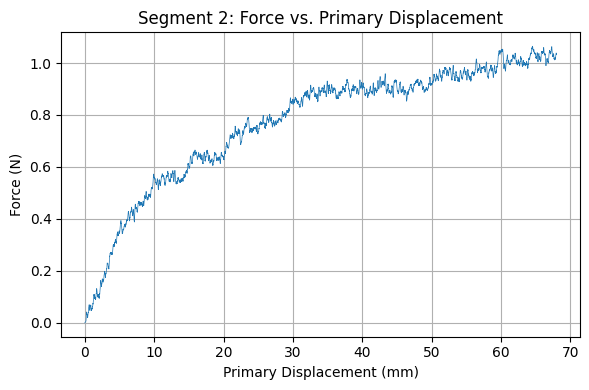

In [4]:
from scipy.signal import savgol_filter
n_lines = 21
seg2 = df_UW[df_UW["Segment No."] == 1]
seg2["Force (N) Smoothed"] = savgol_filter(seg2["Strain Gauge Load Cell (N)"], window_length=51, polyorder=3)
baseline_force = seg2["Force (N) Smoothed"].iloc[0]
seg2["Force (N)"] = seg2["Force (N) Smoothed"] - baseline_force
# Plot
Disp_mm_UW = seg2["Primary Encoder Displacement (m)"]*1000
Force_N_UW = seg2["Force (N)"]/n_lines
A_mm_UW = 0.078294515
l0_mm_UW = 130*0.5
stress_MPa_UW = Force_N_UW/A_mm_UW
strain__UW = Disp_mm_UW/l0_mm_UW

plt.figure(figsize=(6, 4))
plt.plot(seg2["Primary Encoder Displacement (m)"]*1000, seg2["Force (N)"]/n_lines, lw=.5)
plt.xlabel("Primary Displacement (mm)")
plt.ylabel("Force (N)")
plt.title("Segment 2: Force vs. Primary Displacement")
plt.grid(True)
plt.tight_layout()
plt.show()


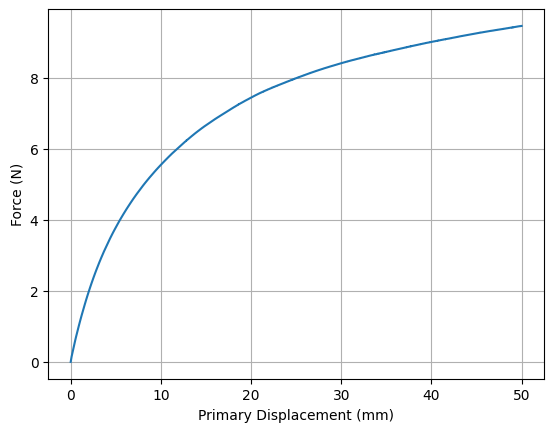

In [5]:
import numpy as np
file_path = os.path.join(BYU_root, 'Avg_Stress_Strain_Overture_TPU.csv')
df = pd.read_csv(file_path)
strain_columns = [col for col in df.columns if 'Strain' in col]
stress_columns = [col for col in df.columns if 'Stress' in col]

strain_df = np.array(df[strain_columns])
stress_df = np.array(df[stress_columns])
Amm = 1
L0mm = 100
Force_N = stress_df * Amm
Disp_m = strain_df*L0mm

fig, ax = plt.subplots(1)
ax.plot(Disp_m, Force_N)
ax.grid(True)
ax.set_xlabel("Primary Displacement (mm)")
ax.set_ylabel("Force (N)")

file_path = os.path.join(BYU_root, 'Avg_Stress_Strain_Overture_TPU_1mm2.csv')
df_1mm2 = pd.read_csv(file_path)
strain_columns_1mm2 = [col for col in df_1mm2.columns if 'Strain' in col]
stress_columns_1mm2 = [col for col in df_1mm2.columns if 'Stress' in col]

strain_df_1mm2 = np.array(df_1mm2[strain_columns])
stress_df_1mm2 = np.array(df_1mm2[stress_columns])

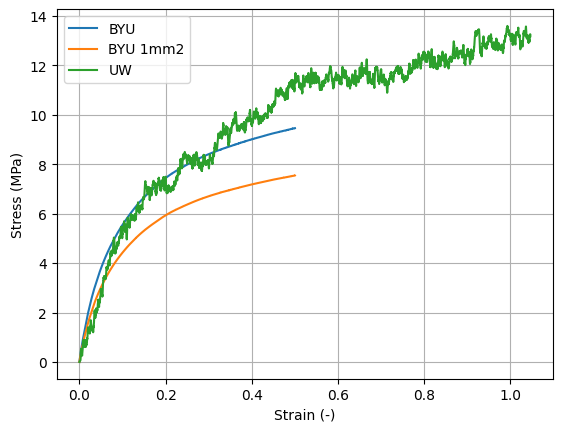

In [6]:
# %matplotlib qt
fig, ax = plt.subplots(1)
ax.plot(strain_df, stress_df, label = "BYU")
ax.plot(strain_df_1mm2, stress_df_1mm2, label = "BYU 1mm2")
ax.plot(strain__UW, stress_MPa_UW, label = "UW")
ax.grid(True)
ax.set_xlabel("Strain (-)")
ax.set_ylabel("Stress (MPa)")
ax.legend()

In [21]:
model_name

'unit_cell_loop_size_q_(13, 14, 0.35)_0.79'

In [31]:
%matplotlib qt
import glob
from src.network import Network_custom
BYU_UW_root = r"G:\.shortcut-targets-by-id\1k1B8zPb3T8H7y6x0irFZnzzmfQPHMRPx\Illimited Lab Projects\Research Projects\Spiders\BYU-UW"
calibration_results_files = glob.glob(os.path.join(BYU_UW_root, 'calibration_results', '*_cr.npy'))

calib_file = calibration_results_files[5]
try:
    data = np.load(calib_file, allow_pickle=True).item()
except:
    print(f'for some reason {calib_file} stopped working')

model_name_im = data['model_name_im']
model_name = data['model_name']
real_vertices = data['real_vertices']
vertices_equilibrium = data['equilibrium_vertices']
homography_real_to_px =  data['homography_matrix']
homography_px_to_real = data['homography_matrix_inv'],



print(model_name)
try:
    net2 = Network_custom.load_network(os.path.join(BYU_UW_root, 'networks', model_name + '.pkl'))
except:
    net2 = Network_custom.load_network(os.path.join(BYU_UW_root, 'networks', model_name + '_net.pkl')) 

image_name = model_name_im + ".JPG"
image_path = os.path.join(BYU_UW_root, 'measurement images', image_name)
original_image = plt.imread(image_path)

approx_shift = np.array([1.8 * np.max(net2.vertices[:, 0]), 1.5 * np.max(net2.vertices[:, 1]), 0.0])
approx_scale = 20


vertices_equilibrium_px = np.copy(vertices_equilibrium)
vertices_equilibrium_px += approx_shift
vertices_equilibrium_px *= approx_scale
vertices_equilibrium_px = net2.apply_homography(vertices_equilibrium_px, homography_real_to_px)

real_vertices_px = np.copy(real_vertices)
real_vertices_px += approx_shift[:2]
real_vertices_px *= approx_scale
real_vertices_px = net2.apply_homography(real_vertices_px, homography_real_to_px)

strain_to_stress2 = net2.material_model(strain_df[:,0], stress_df[:,0])
vertices2, l12, f2 = net2.find_equilibrium(real_vertices, net2.A, strain_to_stress2)
vertices2_px = np.copy(vertices2)
vertices2_px += approx_shift[:2]
vertices2_px *= approx_scale
vertices2_px = net2.apply_homography(vertices2_px, homography_real_to_px)

fig, ax = plt.subplots(figsize=(15, 10))
ax.axis('off')
ax.set_aspect('equal')
ax.imshow(original_image)
ax = net2.net_plot_mat(ax, vlabels=True, fp=True, vertices_c=vertices_equilibrium_px)
ax = net2.net_plot_mat(ax, vlabels=False, fp=True, vertices_c=vertices2_px)
ax.plot(real_vertices_px[:, 0], real_vertices_px[:, 1], 'ko', markersize=3, label='Real vertices')
ax.plot(real_vertices_px[net2.fixed,0], real_vertices_px[net2.fixed,1], 'b*', markersize=5, label='Fixed points - designed')
# ax.set_xlim(np.min(vertices_px[net.fixed,0]) - 100, np.max(vertices_px[net.fixed,0])+ 100)
# ax.set_ylim(np.max(vertices_px[net.fixed,1])+ 100, np.min(vertices_px[net.fixed,1])- 100)
ax.legend(fontsize=12)

unit_cell_even_q_1.0_10
`gtol` termination condition is satisfied.
